<a href="https://colab.research.google.com/github/thiagomelostuckert/datathon-fakenews/blob/main/1_An%C3%A1lise_Gr%C3%A1fica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Análise gráfica da base de dados e preparação para construção de modelo de detecção utilizando técnicas de aprendizado de máquina

A equipe recebeu em anexo os arquivos ‘train_data.csv’ e ‘train_labels.csv’. O arquivo ‘train_data.csv’ contém 6480 notícias verdadeiras ou falsas, sendo o respectivo rótulo indicado no arquivo ‘train_labels.csv’. Já foi feito um primeiro preprocessamento nos textos das notícias (que não impede novas etapas de preprocessamento se assim a equipe julgar necessário).
A base de dados original utilizada está disponível no github (https://github.com/roneysco/Fake.br-Corpus/tree/master) e foi utilizada na tese de doutorado do Dr. Roney Lira de Sale Santos. A escolha da base de dados foi determinada por critérios estritamente didáticos, e a rotulação dos dados não foi validada pela ABIN.
Competirá principalmente ao analista de dados a análise exploratória gráfica da base de dados para gerar as primeiras impressões e informações sobre cada tipo de notícia. Sugere-se as bibliotecas padrão do Python para esta finalidade, como Matplotlib, seaborn, pandas e plotly.
Além disso, o analista de dados deverá preparar a base de dados para ser utilizada pelo cientista de dados, o que envolve preparação específica a partir do modelo escolhido por este último.
A avaliação dessa etapa se dará a partir da pertinência, completude e eficiência de código das visualizações geradas da base de dados.

Importação das bibliotecas

In [ ]:
import pandas as pd

# Pré-processamento
import nltk
from nltk.stem import RSLPStemmer
from nltk.stem.wordnet import WordNetLemmatizer

# Criação da nuvem de palavras
#!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import numpy as np
from os import path
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Conversão do texto em uma matriz TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

#Utilizados na hora de salvar o arquivo com a matriz TF-IDF
import gzip
import pickle


### Leitura do arquivo pré-processado

In [ ]:
#Leitura dos textos
url_train_data = "https://raw.githubusercontent.com/thiagomelostuckert/datathon-fakenews/main/train_data.csv"
df_train_data = pd.read_csv(url_train_data, on_bad_lines = 'warn')

In [ ]:
#Leitura das labels
url_train_label = "https://raw.githubusercontent.com/thiagomelostuckert/datathon-fakenews/main/train_labels.csv"
df_train_label = pd.read_csv(url_train_label, on_bad_lines = 'warn')

### Análises dos *dados*

In [ ]:
#Apresenta as colunas do dataframe
print(df_train_data.columns)
print(df_train_label.columns)

Index(['preprocessed_news'], dtype='object')
Index(['label'], dtype='object')


In [ ]:
#Junta os dois datasets em um único dataframe
df = pd.merge(df_train_data, df_train_label, left_index=True, right_index=True)
df.columns

Index(['preprocessed_news', 'label'], dtype='object')

In [ ]:
#Mostra a quantidade de notícias falsas e verdadeiras
df['label'].value_counts()

fake    3240
true    3240
Name: label, dtype: int64

<Axes: >

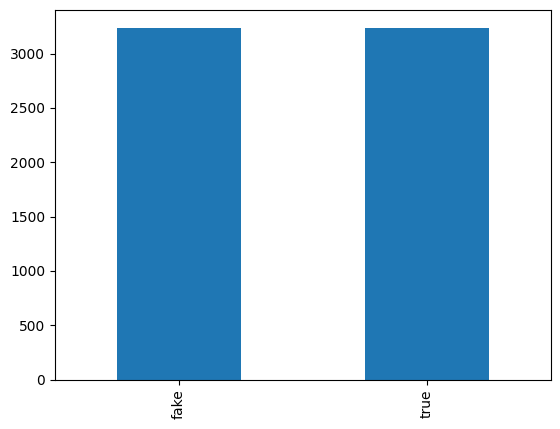

In [ ]:
# Apresenta gráfico com a quantidade de notícias falsas e verdadeiras
# Observamos que o dataset está balanceado
df['label'].value_counts().plot.bar()

In [ ]:
#Mostra as primeiras linhas do dataframe
df.head()

,preprocessed_news,label
0,suica encontra contas ilicitas usadas abastece...,fake
1,genro silvio santos lista lava jato silvio san...,fake
2,linha credito imobiliario tera orcamento menor...,true
3,cerimonia oscar ultimo domingo mulheres roubar...,true
4,pais usa calor internet aquecer casas projeto ...,true


Contagem da frequência das palavras

In [ ]:
df_true = df[df.label == "true"]

In [ ]:
#Quantidade de palavras analisadas
qtde_palavras=50

In [ ]:
df_true_word_count = df_true.preprocessed_news.str.split(expand=True).stack().value_counts().sort_values(ascending=False).rename_axis('Palavras').reset_index(name='Frequência')

df_true_word_count_first = df_true_word_count[:qtde_palavras]
df_true_word_count_first

,Palavras,Frequência
0,nao,32379
1,sao,8720
2,ser,8716
3,tambem,8610
4,presidente,7849
5,lula,7826
6,sobre,7488
7,disse,7351
8,anos,7347
9,federal,6802


<Figure size 1500x1000 with 0 Axes>

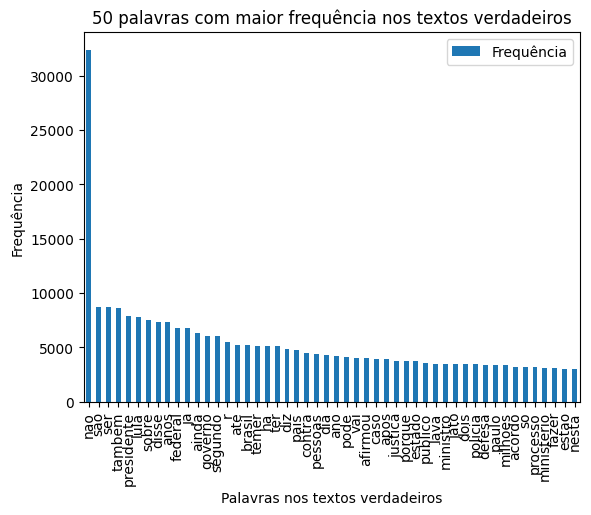

In [ ]:
plt.figure(figsize=(15,10))
df_true_word_count_first.plot.bar(x='Palavras', y='Frequência')
plt.title(f"{qtde_palavras} palavras com maior frequência nos textos verdadeiros")
plt.xticks(rotation=90)
plt.xlabel("Palavras nos textos verdadeiros")
plt.ylabel("Frequência")
plt.show()

In [ ]:
df_true_word_count_least = df_true_word_count.tail(qtde_palavras)
df_true_word_count_least

,Palavras,Frequência
71259,nelito,1
71260,influenciavel,1
71261,mesulam,1
71262,desafiadores,1
71263,monitoravam,1
71264,exaustos,1
71265,pencas,1
71266,cerra,1
71267,assassinam,1
71268,insuspeita,1


<Figure size 1500x1000 with 0 Axes>

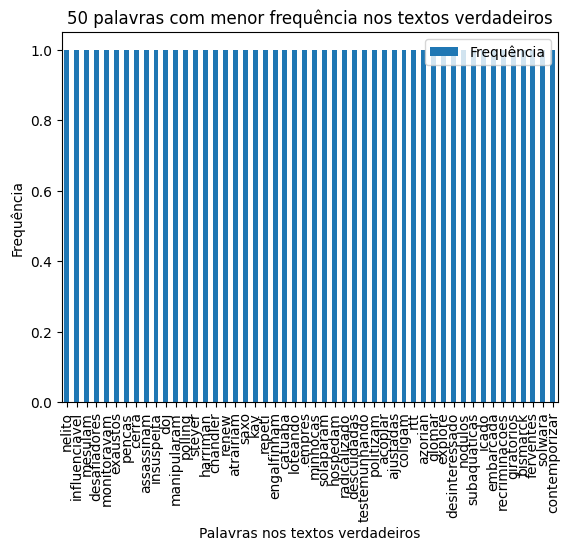

In [ ]:
plt.figure(figsize=(15,10))
df_true_word_count_least.plot.bar(x='Palavras', y='Frequência')
plt.title(f"{qtde_palavras} palavras com menor frequência nos textos verdadeiros")
plt.xticks(rotation=90)
plt.xlabel("Palavras nos textos verdadeiros")
plt.ylabel("Frequência")
plt.show()

In [ ]:
# Reparei que muitas palavras tem apenas uma ocorrência
word_freq_1 = df_true_word_count[df_true_word_count.Frequência == 1]["Frequência"].count()
word_freq_1

26057

In [ ]:
word_freq_total_true = df_true_word_count["Frequência"].count()
word_freq_total_true

71309

In [ ]:
percentual_word_freq_1 = (word_freq_1/word_freq_total_true)*100
print("{:.2f}% das palavras tem apenas uma única ocorrência".format(percentual_word_freq_1))

36.54% das palavras tem apenas uma única ocorrência


In [ ]:
df_fake = df[df.label == "fake"]

In [ ]:
df_fake_word_count = df_fake.preprocessed_news.str.split(expand=True).stack().value_counts().sort_values(ascending=False).rename_axis('Palavras').reset_index(name='Frequência')
df_fake_word_count_first = df_fake_word_count[:qtde_palavras]
df_fake_word_count_first

,Palavras,Frequência
0,nao,5648
1,lula,2766
2,disse,1974
3,dilma,1664
4,presidente,1656
5,ser,1483
6,tambem,1443
7,ja,1314
8,sao,1291
9,brasil,1284


<Figure size 1500x1000 with 0 Axes>

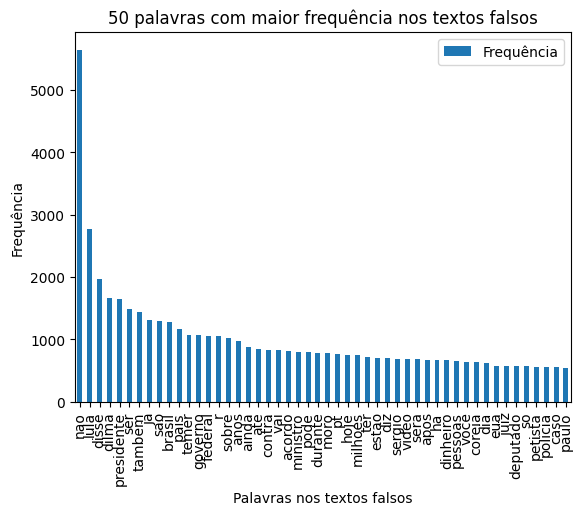

In [ ]:
plt.figure(figsize=(15,10))
df_fake_word_count_first.plot.bar(x='Palavras', y='Frequência')
plt.title(f"{qtde_palavras} palavras com maior frequência nos textos falsos")
plt.xticks(rotation=90)
plt.xlabel("Palavras nos textos falsos")
plt.ylabel("Frequência")
plt.show()

In [ ]:
df_fake_word_count_least = df_fake_word_count.tail(qtde_palavras)
df_fake_word_count_least

,Palavras,Frequência
30336,absorvido,1
30337,entrincheirada,1
30338,estimulasse,1
30339,estimulava,1
30340,visse,1
30341,troia,1
30342,canudos,1
30343,bassi,1
30344,listras,1
30345,constavam,1


<Figure size 1500x1000 with 0 Axes>

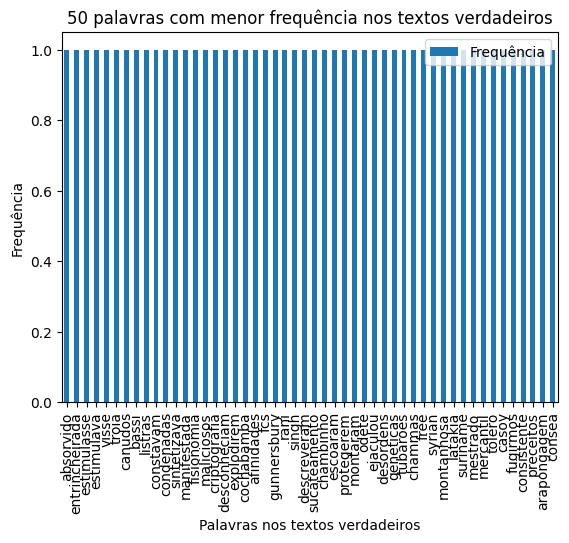

In [ ]:
plt.figure(figsize=(15,10))
df_fake_word_count_least.plot.bar(x='Palavras', y='Frequência')
plt.title(f"{qtde_palavras} palavras com menor frequência nos textos verdadeiros")
plt.xticks(rotation=90)
plt.xlabel("Palavras nos textos verdadeiros")
plt.ylabel("Frequência")
plt.show()

In [ ]:
# Reparei que muitas palavras tem apenas uma ocorrência
word_freq_1 = df_fake_word_count[df_fake_word_count.Frequência == 1]["Frequência"].count()
word_freq_1

12171

In [ ]:
word_freq_total_fake = df_fake_word_count["Frequência"].count()
word_freq_total_fake

30386

In [ ]:
percentual_word_freq_1 = (word_freq_1/word_freq_total_fake)*100
print("{:.2f}% das palavras tem apenas uma única ocorrência".format(percentual_word_freq_1))

40.05% das palavras tem apenas uma única ocorrência


In [ ]:
print(f"Reparei que a variedade de palavras diferentes nos textos verdadeiros ({word_freq_total_true}) é maior do que nos textos falsos ({word_freq_total_fake}). ")
print("Isso pode ser um indicativo que os textos falsos tem um vocabulário mais limitado.")


Reparei que a variedade de palavras diferentes nos textos verdadeiros (71309) é maior do que nos textos falsos (30386). 
Isso pode ser um indicativo que os textos falsos tem um vocabulário mais limitado.


In [ ]:
# Cruzamento das palavras mais frequentes nos textos falsos e verdadeiros
df_all_word_count_first = pd.merge(df_fake_word_count_first,df_true_word_count_first, how ='outer', on =['Palavras', 'Palavras'], suffixes=('_fake','_true'), indicator=True)
df_all_word_count_first.head(2*qtde_palavras)


,Palavras,Frequência_fake,Frequência_true,_merge
0,nao,5648.0,32379.0,both
1,lula,2766.0,7826.0,both
2,disse,1974.0,7351.0,both
3,dilma,1664.0,NaN,left_only
4,presidente,1656.0,7849.0,both
...,...,...,...,...
60,defesa,NaN,3382.0,right_only
61,processo,NaN,3185.0,right_only
62,ministerio,NaN,3095.0,right_only
63,fazer,NaN,3083.0,right_only


In [ ]:
# As palavras que aparecem com mais frequência tanto nos textos falsos quanto verdadeiros
df_fake_and_true_first = df_all_word_count_first[df_all_word_count_first['_merge'] == 'both']
df_fake_and_true_first.head(qtde_palavras)

,Palavras,Frequência_fake,Frequência_true,_merge
0,nao,5648.0,32379.0,both
1,lula,2766.0,7826.0,both
2,disse,1974.0,7351.0,both
4,presidente,1656.0,7849.0,both
5,ser,1483.0,8716.0,both
6,tambem,1443.0,8610.0,both
7,ja,1314.0,6769.0,both
8,sao,1291.0,8720.0,both
9,brasil,1284.0,5219.0,both
10,pais,1170.0,4715.0,both


In [ ]:
# As palavras que aparecem com mais frequência apenas nos textos falsos
df_fake_only_first = df_all_word_count_first[df_all_word_count_first['_merge'] == 'left_only']
df_fake_only_first.head(qtde_palavras)

,Palavras,Frequência_fake,Frequência_true,_merge
3,dilma,1664.0,NaN,left_only
24,durante,788.0,NaN,left_only
25,moro,784.0,NaN,left_only
26,pt,768.0,NaN,left_only
27,hoje,753.0,NaN,left_only
32,sergio,679.0,NaN,left_only
33,video,678.0,NaN,left_only
34,sera,678.0,NaN,left_only
37,dinheiro,670.0,NaN,left_only
39,voce,640.0,NaN,left_only


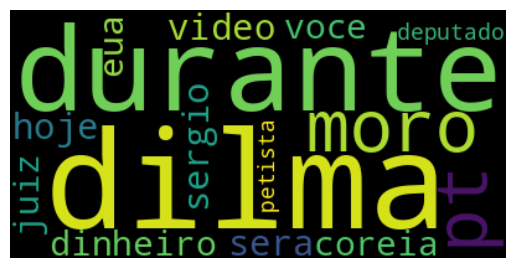

In [ ]:
# Nuvem de palavras que aparecem com mais frequência nos textos falsos
text = " ".join(news for news in df_fake_only_first.Palavras)

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
# As palavras que aparecem com mais frequência apenas nos textos verdadeiros
df_true_only_first = df_all_word_count_first[df_all_word_count_first['_merge'] == 'right_only']
df_true_only_first.head(qtde_palavras)

,Palavras,Frequência_fake,Frequência_true,_merge
50,segundo,NaN,6052.0,right_only
51,ano,NaN,4234.0,right_only
52,afirmou,NaN,4019.0,right_only
53,justica,NaN,3743.0,right_only
54,porque,NaN,3712.0,right_only
55,estado,NaN,3706.0,right_only
56,publico,NaN,3557.0,right_only
57,lava,NaN,3484.0,right_only
58,jato,NaN,3477.0,right_only
59,dois,NaN,3433.0,right_only


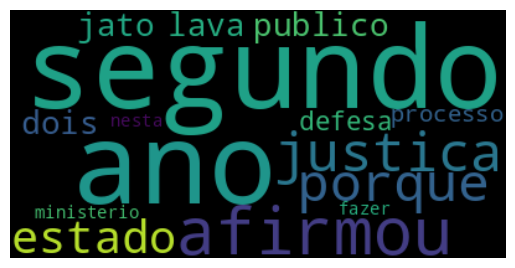

In [ ]:
# Nuvem de palavras que aparecem com mais frequência nos textos verdadeiros
text = " ".join(news for news in df_true_only_first.Palavras)

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Tratamento dos dados para servir como entrada dos modelos de aprendizado de máquina
Na próxima etapa da construção do modelo de aprendizado de máquina será necessário transformar os textos em uma matriz de frequências invertidas das palavras, conhecida em inglês por term Frequency - Inverse Document Frequency (TF-IDF). Para isso podemos utilizar a biblioteca sklearn TfidfVectorizer

Referências:
https://www.learndatasci.com/glossary/tf-idf-term-frequency-inverse-document-frequency

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

https://www.educative.io/answers/how-to-use-tf-idf-vectorizer-on-dataframe

In [ ]:
df.shape

(6480, 2)

In [ ]:
#Cria o vectorizer que será preenchido com as frequências
vectorizer = TfidfVectorizer()
#Popula com as frequências dos textos
X = vectorizer.fit_transform(df.preprocessed_news)
print(X.toarray())
print(X.shape)

with gzip.open('matrix-tf-idf.pkl', 'wb') as f:
    pickle.dump(X, f)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(6480, 76289)


In [ ]:
# Vocabulário dos textos
tfidf_tokens = vectorizer.get_feature_names_out()
tfidf_tokens

array(['aa', 'aabb', 'aabertura', ..., 'zwi', 'zygmun', 'zygmunt'],
      dtype=object)

### Hipótese textos falsos possuem vocabulário mais pobre

In [ ]:
# baixando o corpus de palavras extraídas de textos jornalísticos da Folha de São Paulo
nltk.download('mac_morpho')
corpus_FolhaSP = nltk.corpus.mac_morpho.words()

[nltk_data] Downloading package mac_morpho to /root/nltk_data...
[nltk_data]   Package mac_morpho is already up-to-date!


Quantidade de palavras no corpus da Folha de São Paulo: 1170095


In [ ]:
print(f"Quantidade de palavras no corpus da Folha de São Paulo: {len(corpus_FolhaSP)}")

In [ ]:
true_texts = df_true.preprocessed_news.to_list()
true_words = []
for text in true_texts:
  true_words+=text.split()
print(f"As três primeiras palavras em textos verdadeiros: {true_words[:3]}")
print(f"A quantidade de palavras: {len(true_words)}")

As três primeiras palavras em textos verdadeiros: ['linha', 'credito', 'imobiliario']
A quantidade de palavras: 2019744


In [ ]:
# Um jeito mais complicado de fazer a mesma operação
df_words_true = df_true.preprocessed_news.str.split(expand=True).stack().reset_index()[0].tolist()
print(f"A quantidade de palavras obtidas por esse outro método: {len(df_words_true)}")


In [ ]:
#Remove as palavras duplicadas
unique_true_words = list(set(true_words))
print(f"Quantidade de palavras sem duplicidade em textos verdadeiros: {len(unique_true_words)}")


Quantidade de palavras sem duplicidade em textos verdadeiros: 71309


In [ ]:
%time
# Atenção essa célula demora para executar e não está retornando um bom resultado
#Verifica quais dessas palavras não constam no corpus da Folha de São Paulo
not_found_words = []
for word in unique_true_words:
  if word not in corpus_FolhaSP:
    print(word)
    not_found_words+=word
print(f"Quantidade de palavras de textos verdadeiros fora do corpus da Folha de SP {len(not_found_words)}")

pulbicos
reconnaissance
zombou
acompanharao
caudalosos
juridicas
ericson
posicionarem
anulada
ideia
competirem
bpe
keith
eunicio
caramelows
agregam
jbs
realizassem
durma
zoando
instabilidades
finalizarem
apatow
drone
thieringer
sabotar
foquinha
ons
gue
pbs
imensuravel
changed
reeducacao
dbo
borrifado
bonder
esfaqueava
meteorologicos
desgastadas
corajosamente
transforme
odontologico
mutti
banhistas
lamentada
trellez
criminalizada
prendemos
cabrera
estamento
isa
atrapalharia
florestais
camarotti
limitador
thomaz
esgotava
enxergarem
condolentes
savoy
meet
drogarias
lorenna
reprodutivos
aquella
enxerguem
substituiria
tecnobus
lain
reservara
cavalli
manifestamos
wolfram
steinmeyer
centre
anonima
israel
usufruindo
herdamos
propagandista
suposicoes
saviano
creek
moela
importasse
tacs
benidorm
encerrasse
infringindo
cumpriremos
aliviou
provocadores
fte
refratarias
antinatural
reinauguracao
aarhus
agepar
degolas
ask
curtidas
culminaram
tajiquistao
gadu
hani
engravidei
corat
homologados
pokemon


KeyboardInterrupt: ignored

In [ ]:
not_found_words[:5]

In [ ]:
# Também pode-se avaliar se são usados mais substantivos ou verbos
# https://www.linguateca.pt/Floresta/

### Não será necessário agora
### Pré-processamento do texto

No pré-processamento de linguagem natural é comum retirar palavras sem significado semântico (conhecidas em inglês como "stop words").

In [ ]:
# Stopwords em português:
nltk.download('stopwords')
stopwordspt = nltk.corpus.stopwords.words('portuguese')
stopwordsen = nltk.corpus.stopwords.words('english')
stopwordspt[:10]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['a',
 'à',
 'ao',
 'aos',
 'aquela',
 'aquelas',
 'aquele',
 'aqueles',
 'aquilo',
 'as']

Outro pré-processamento possível é a retirada de prefixos e sufixos desnecessários das palavras ( processo conhecido em inglês pelos termos "lemmatizing and stemming")

In [ ]:
# Download lista de radicais e sufixos
!wget https://github.com/michmech/lemmatization-lists/raw/master/lemmatization-pt.txt -q
nltk.download('rslp')

ptstemmer = RSLPStemmer()
enstemmer = WordNetLemmatizer()

# Convert to dictionary
lmztpt = {}
dic = open("lemmatization-pt.txt")
for line in dic:
  txt = line.split()
  lmztpt[txt[1]] = txt[0]

# Lemmatize wherever possible
def PortugueseMess(word):
  if word in lmztpt.keys():
    return lmztpt.get(word)
  else:
    return ptstemmer.stem(word)


[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.
